## Implementing Gradient Boosting Machine for ID3 Algorithm Based Decision Tree Classifier

In [1]:
import numpy as np 
import pandas as pd
import math 
import operator
import random
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy    # deep copies
import csv

In [2]:
#Input data

data=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
#Subroutine to calculate Shannon Entorpy

def entropy(p):
    if p!=0:
        return -p*np.log2(p)
    else:
        return 0        

### Following code snippet implements calculation for information gain. This attribute is used to select the best feature to split the decision tree on.

In [4]:
def info_gain(data,classes,feature):
    #prepare list of feature classes
    overallClasses={classes[0]:0,classes[1]:0}
    FeatureClasses={}
    for i in range(0,len(data)):
        if (data.iloc[i][feature] not in FeatureClasses.keys()):
            if pd.notnull(data.iloc[i][feature]):
                FeatureClasses[data.iloc[i][feature]]=[0,0,0]
    #loop through the data to count the number of +ve and -ve example for each features type in the feature column
    #total number of examples corresponding to each feature type is sum of +ve and -ve
    for i in range(0,len(data)):
        if  pd.notnull(data.iloc[i][feature]):        
            if data.iloc[i]['Survived']==classes[0]:
                FeatureClasses[data.iloc[i][feature]][0]+=1
                FeatureClasses[data.iloc[i][feature]][2]+=1
            else:
                FeatureClasses[data.iloc[i][feature]][1]+=1
                FeatureClasses[data.iloc[i][feature]][2]+=1
    #get the overall count
    for keys in FeatureClasses.keys():
        overallClasses[0]+=FeatureClasses[keys][0]
        overallClasses[1]+=FeatureClasses[keys][1]
        
    overallEntropy=entropy(overallClasses[0]/len(data))+entropy(overallClasses[1]/len(data))
    #final entropy after dividing the data on the basis of feature
    FinalEntropy=0
    for keys in FeatureClasses.keys():
        FinalEntropy+=entropy(FeatureClasses[keys][0]/FeatureClasses[keys][2])
    
    InformationGain=overallEntropy-FinalEntropy
        
    return InformationGain

### Creating leaf nodes

In [5]:
def create_leaf(data):
    leaf = {'splitting_feature' : None,
            'children' : None,
            'is_leaf':  True}
    
    ones=data['Survived'][data['Survived']==1].count()
    zeroes=data['Survived'][data['Survived']==0].count()
    
    if ones>zeroes:
        leaf['Prediction']=1
    else:
        leaf['Prediction']=0
    
    return leaf

### Subroutine to calculate best feature to split upon. This subroutine uses "info_gain" subroutine implemented above 

In [6]:
def best_splitting_feature(data):
    Features=list(data)
    Features.remove('Survived')
    FeatureEntropies={}
    for colNames in Features:
        FeatureEntropies[colNames]=info_gain(data,[0,1],colNames)
    
    return max(FeatureEntropies, key=FeatureEntropies.get)

### Subroutine for recursively creating the tree

In [7]:
def create_tree(data, depth, maxdepth):
    if(len(list(data))==1):
        return create_leaf(data)
    
    if(len(data)==0):
        return create_leaf(data)
    
    if(depth>=maxdepth):
        return create_leaf(data)

    splitting_feature=best_splitting_feature(data)
    uniqueFeatures=data[splitting_feature][pd.notnull(data[splitting_feature])].unique()
    
    uniqueFeaturesDict={}
    children={}
    for uqFea in uniqueFeatures:
        children[uqFea]=None
        uniqueFeaturesDict[uqFea]=data[data[splitting_feature]==uqFea]
        uniqueFeaturesDict[uqFea]=uniqueFeaturesDict[uqFea].drop(splitting_feature,axis=1)
    
    for uqFea in uniqueFeatures:
        children[uqFea]=create_tree(uniqueFeaturesDict[uqFea],depth+1, maxdepth)
        
    return {'splitting_feature' : splitting_feature,
            'children': children,
            'is_leaf':  False}

In [172]:
data['e'] = pd.Series(np.random.randn(len(data)), index=data.index)
msk = np.random.rand(len(data['e'])) <= 0.7
data_train=data[msk]
data_test=data[~msk]
#features = ['Embarked','Pclass','Survived']
#tree=create_tree(data_train[features],0,2)

In [167]:
features = ['Embarked','Pclass','Survived','SibSp','Parch']
tree=create_tree(data_train[features],0,1)

###  Following snippet implements various subroutines to plot a decision tree. It uses matplotlib annotations.

In [10]:
def getNumLeafs(node):
    if(node['is_leaf']==True):
        return 1
    count=0
    for child in node['children'].keys():
        count+=getNumLeafs(node['children'][child])
    
    return count

def getTreeDepth(node):
    if(node['is_leaf']==True):
        return 1
    
    maxDepth=0
    for child in node['children'].keys():
        depth=1+getTreeDepth(node['children'][child])
        if depth>maxDepth:
            maxDepth=depth
    return maxDepth

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,
    xycoords='axes fraction',
    xytext=centerPt, textcoords='axes fraction',
    va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    getTreeDepth(myTree)
    firstStr = myTree['splitting_feature']
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree['children']
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if secondDict[key]['is_leaf']==False:
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key]['Prediction'], (plotTree.xOff, plotTree.yOff),cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

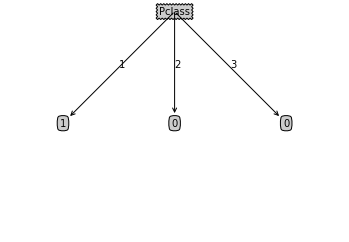

In [168]:
createPlot(tree)

### Subroutine to classify new data points using the above desicion tree

In [151]:
def classify(tree, data):
    if(tree['is_leaf']==True):
        return tree['Prediction']
    
    if data[tree['splitting_feature']] not in tree['children'].keys():
        return 0
    
    featureVal=None
    for feats in tree['children'].keys():
        if data[tree['splitting_feature']]==feats:
            featureVal=feats 
    prediction=classify(tree['children'][featureVal],data)
    
    return prediction    

## Checking accuracy of built tree

In [173]:
count=0
for i in range(0,len(data_test)):
    pred=classify(tree,data_test.iloc[i])
    if pred==data_test.iloc[i]['Survived']:
        count+=1
        
print(count/len(data_test)*100)

65.0909090909091


#### Result:

This decision tree stump is a weak learner/classifier. Further below we will try to implement a Gradient Bossting Machine to form an ensemble of a number of such weak classifiers and use it predict on the same test data set. 

## Classifying Titanic data on real test data

In [21]:
features = ['Embarked','Pclass','SibSp','Parch']
test=test[features]
pred=[]
for i in range(0,len(test)): 
    pred.append(classify(tree,test.iloc[i]))      

In [22]:
with open("output1.csv", "w") as f:
    writer = csv.writer(f,lineterminator='\n')
    writer.writerows([pred])

### Gradient Boosting Routine

This routine has been implemented on the basis the algorithm given in ***Elements of Statistical Learning***

In [14]:
def best_splitting_feature_boosting(data):
    Features=list(data)
    Features.remove('Survived')
    Features.remove('Residuals')
    FeatureEntropies={}
    for colNames in Features:
        FeatureEntropies[colNames]=info_gain(data,[0,1],colNames)
    
    return max(FeatureEntropies, key=FeatureEntropies.get)

In [15]:
def create_tree_boosting(data, depth, maxdepth):
    if(len(list(data))==1):
        return create_leaf_boosting(data)
    
    if(len(data)==0):
        return create_leaf_boosting(data)
    
    if(depth>=maxdepth):
        return create_leaf_boosting(data)

    splitting_feature=best_splitting_feature_boosting(data)
    uniqueFeatures=data[splitting_feature][pd.notnull(data[splitting_feature])].unique()
    
    uniqueFeaturesDict={}
    children={}
    for uqFea in uniqueFeatures:
        children[uqFea]=None
        uniqueFeaturesDict[uqFea]=data[data[splitting_feature]==uqFea]
        uniqueFeaturesDict[uqFea]=uniqueFeaturesDict[uqFea].drop(splitting_feature,axis=1)
    
    for uqFea in uniqueFeatures:
        children[uqFea]=create_tree_boosting(uniqueFeaturesDict[uqFea],depth+1, maxdepth)
        
    return {'splitting_feature' : splitting_feature,
            'children': children,
            'is_leaf':  False}

In [16]:
def create_leaf_boosting(data):
    leaf = {'splitting_feature' : None,
            'children' : None,
            'is_leaf':  True}
    
    leaf['Prediction']=np.mean(data['Residuals'])
    
    return leaf

In [17]:
def add_gamma(tree, data):
    
    if(tree['is_leaf']==True):
        tree['gamma']=(1/2)*(sum(data['Residuals'])/sum(abs(data['Residuals'])*(1-abs(data['Residuals']))))
        return tree
    
    for feats in tree['children'].keys():
        add_gamma(tree['children'][feats],data[data[tree['splitting_feature']]==feats])
    
    return tree

In [18]:
def return_gamma(tree, data):
    if(tree['is_leaf']==True):
        return tree['gamma']
    
    if data[tree['splitting_feature']] not in tree['children'].keys():
        return 0
    
    featureVal=None
    for feats in tree['children'].keys():
        if data[tree['splitting_feature']]==feats:
            featureVal=feats 
    prediction=return_gamma(tree['children'][featureVal],data)
    
    return prediction 

In [117]:
def GBM(data,ls):
    data_train=data.sample(n=707)
    ls.remove('Survived')
    ls.remove('Residuals')
    M=5
    #Note: Learners are basically trees
    learners = [0]*M
    #Note: f are classifiers
    f = [0]*(len(data_train)+1)
    for i in range(0,M):
        rand_smpl = [ ls[i] for i in sorted(random.sample(range(len(ls)), 1)) ]
        rand_smpl.append('Survived')
        rand_smpl.append('Residuals')
        data_train=data_train[rand_smpl]
        r = [0]*len(data_train)
        _f = [f * -1 for f in f]
        p = np.exp(f)/(np.exp(f)+np.exp(_f))
        #print("Probability of 0th data at",i,p[0])
        for k in range(0,len(data_train)):
            #Note: calculate residuals for each data point
            r[k]=data_train.iloc[k]['Survived']-p[k]  
        #Note: add these reisduals in the data
        data_train['Residuals']=r
        #Note: Fit a regression tree to the residuals
        learners[i]=create_tree_boosting(data_train,0,1)
        #createPlot(learners[i])
        #Note: Compute gamma for every leaf node
        learners[i]=add_gamma(learners[i],data_train)
        for k in range(0,len(data_train)):
            f[k]=f[k]+return_gamma(learners[i],data_train.iloc[k])
        data_train=data.sample(n=707)
    return learners    

In [132]:
#data_train=data_train[pd.notnull(data_train['Embarked'])]
features = ['Sex','Embarked','Pclass','Survived','Residuals','SibSp','Parch']
data_train['Residuals']=0
boost_trees=GBM(data_train[features],features)

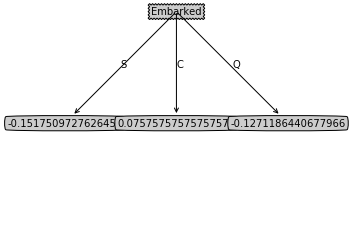

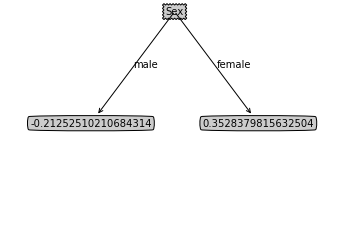

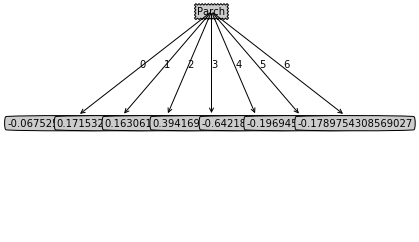

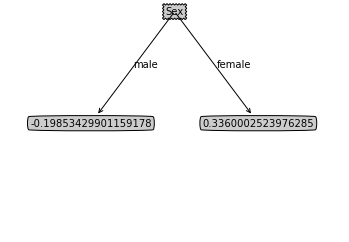

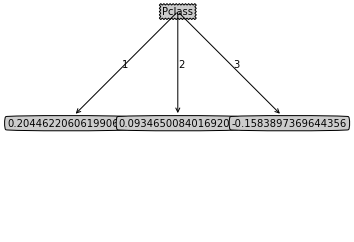

In [131]:
for i in boost_trees:
    createPlot(i)

### Checking accuracy of the Boosted Machine

In [119]:
def classify_boost(trees,data):
    f=0
    #print(len(trees))
    for i in range(0,len(trees)):
        f=f+return_gamma(trees[i],data) 
    #print(f)
    if f>=0:
        return 1
    else:
        return 0

In [133]:
features2 = ['Sex','Embarked','Pclass','Survived','SibSp','Parch']
data_test2=data_test[features2][pd.notnull(data_test['Embarked'])]
count2=0
for i in range(0,len(data_test2)):
    pred2=classify_boost(boost_trees,data_test2.iloc[i])
    #print(pred2)
    #print(data_test.iloc[i]['Survived'])
    if pred2==data_test2.iloc[i]['Survived']:
        count2+=1
        
print(count2/len(data_test2)*100)

78.2122905027933


#### Result:

The boosted machine is giving a success rate of 78.21 % on the unseen test data. For the same unseen test data, desicion tree stump gave a success rate of 65.1 %, which has been given above. This amounts to a betterment of ~25 % in the success rate, which elaborates the effectiveness of the boosted machine. 

In [ ]:
features = ['Sex','Embarked','Pclass']
test=test[features]
pred=[]
for i in range(0,len(test)): 
    pred.append(classify_boost(boost_trees,test.iloc[i])) 

In [91]:
with open("output1.csv", "w") as f:
    writer = csv.writer(f,lineterminator='\n')
    writer.writerows([pred])